In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

path = os.path.join(os.path.join(os.getcwd(), os.pardir),"data")
print(path)
file = os.path.join(path, "skylab_instagram_datathon_dataset.csv")
data = pd.read_csv(file, delimiter=";")

/home/michal/UBS_Hackathon/datathon/src/../data


# 1. Data Cleaning & Exploration

The data includes a lot of NaN values. We considered several approaches of dealing with such values and settled on linear interpolation. In that way, the general trends in the data are preserved and we don't throw away any useful data. Additionally, there often occurs the case, that there are NaN values at the beginning and the end of the time series data. In this case, we decided to throw away these datapoints, since it's hard to interpolate the ends without disturbing the general statistics of the data.

In [2]:
def clean_dataframe(data, metrics, method: str="linear"):
    data = data.sort_values("period_end_date")
    companies = data["business_entity_doing_business_as_name"].unique()
    new = [None]*len(companies) 
    # Group by the company name and apply interpolation within each group
    for i in range(len(companies)):
        company = companies[i]
        company_idx = (data["business_entity_doing_business_as_name"] == company)
        filtered = data[company_idx]
        filtered[metrics] = filtered[metrics].interpolate(method=method)
        filtered = filtered.dropna(subset=metrics)
        new[i] = filtered

    new_data = pd.concat(new, ignore_index=True)
    return new_data.sort_values("period_end_date")

data["period_end_date"] = pd.to_datetime(data["period_end_date"])

metrics = ["followers", "pictures", "likes", "videos", "comments"]
data = clean_dataframe(data, metrics)

/tmp/ipykernel_17178/3995774140.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[metrics] = filtered[metrics].interpolate(method=method)
/tmp/ipykernel_17178/3995774140.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[metrics] = filtered[metrics].interpolate(method=method)
/tmp/ipykernel_17178/3995774140.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

## Data Counts

number companies:  54


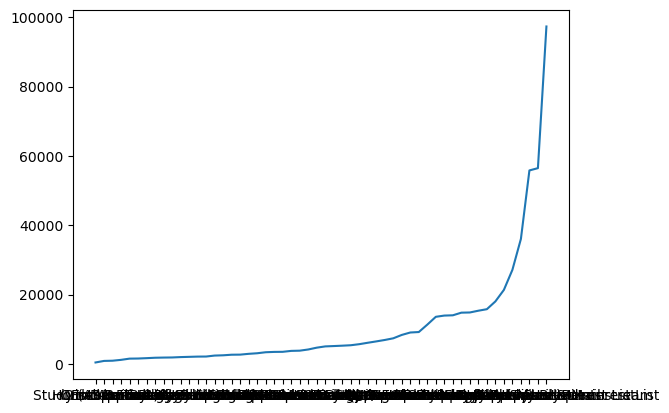

                                     entries   na
Global Luxury Analysts Interest List   27152  NaN
Beauty & Boutique                      36064  NaN
Apparel Retail                         55815  NaN
Luxury & Premium & Mainstream          56471  NaN
US Softlines Analyst Interest List     97310  NaN


In [3]:
import matplotlib.pyplot as plt

def count_entries(data: pd.DataFrame, column: str):
    cats = list(set(list(data["compset"])))
    print("number companies: ", len(cats))

    table = pd.DataFrame(columns=["entries", "na"], index=cats)
    for company in cats:
        data_company = data[data["compset"] == company]
        table.loc[company, "entries"] = len(data_company)
    table = table.sort_values(by=["entries"])
    return table

table = count_entries(data=data, column="compset")
plt.plot(table["entries"])
plt.show()
print(table[-5:])

## Yearly Means

/tmp/ipykernel_17178/2124670848.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.year


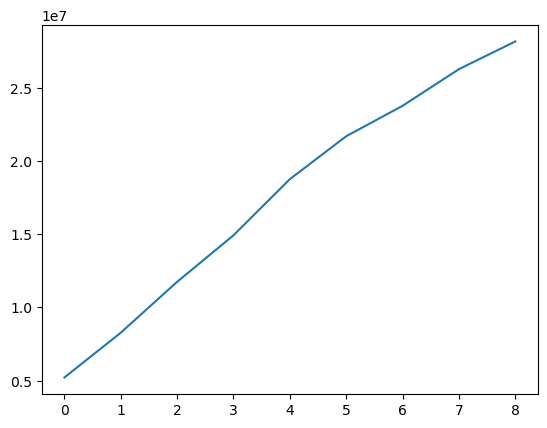

In [4]:
def calculate_yearly_means(df, col, category_column, category_value, period: str="yearly"):
    filtered_df = df[df[category_column] == category_value]
    
    # Convert the index to datetime if it's not already
    if period == "yearly":
        filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.year
    elif period == "montly":
        filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.month

    yearly_means = filtered_df[col].groupby(filtered_df["time"]).mean()
    
    return yearly_means

yearly_means = calculate_yearly_means(data, "followers", "compset", "Soft Luxury", period="yearly")
plt.plot(range(len(yearly_means)), yearly_means)

# 2. Enrichment

To be able to work with more relevant data, we decided to transform our raw data into widely used marketing measures, which better represent the engagement of the customer with companies social media presence.


In [5]:
# Sort the data by company name and period end date
impute_test = data.sort_values(by=['business_entity_doing_business_as_name', 'period_end_date'])

# Group the data by company name
grouped = impute_test.groupby('business_entity_doing_business_as_name')

# For each company, process the data to handle duplicates and compset variations
company_tables = {}
for name, group in grouped:
    # Drop the company name column as it's redundant in individual company dataframes
    group = group.drop(columns='business_entity_doing_business_as_name')
    group.drop_duplicates()
    
    # Group by period_end_date and aggregate
    group = group.groupby('period_end_date').agg({
        'compset': lambda x: list(set(x)),  # Convert compset values to a set to remove duplicates, then to a list
        'followers': 'mean',  # Assuming followers should be averaged
        'pictures': 'sum',  # Summing up the pictures
        'videos': 'sum',    # Summing up the videos
        'comments': 'sum',  # Summing up the comments
        'likes': 'sum'      # Summing up the likes
    }).reset_index()

    # Store the processed DataFrame back to the company_tables dictionary
    company_tables[name] = group


# Iterate over each company in the company_tables
for company, df in company_tables.items():
    # Ensure the data is sorted by date - assuming 'period_end_date' is the weekly identifier
    df = df.sort_values(by='period_end_date')

    # Group by 'period_end_date' to handle data week by week
    weekly_data = df.groupby('period_end_date').agg({
        'likes': 'sum',
        'comments': 'sum',
        'followers': 'mean',  # Assuming 'followers' is stable across the week, we take the mean
        'pictures': 'sum',    # Summing up the number of pictures
        'videos': 'sum'       # Summing up the number of videos
    }).reset_index()

    # Calculate the average engagement per post for the baseline
    weekly_data['average_engagement_per_post'] = (weekly_data['likes'] + weekly_data['comments']) / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)

    # Calculate the engagement rate for each week
    weekly_data['engagement_rate'] = (weekly_data['likes'] + weekly_data['comments']) / weekly_data['followers'] * 100

    # Calculate the like-to-comment ratio for each week
    # I actually think this feature does not make sense
    #weekly_data['like_to_comment_ratio'] = weekly_data['likes'] / (weekly_data['comments'] + 0.001)

    # Calculate the average likes and comments per post for each week
    weekly_data['average_likes_per_post'] = weekly_data['likes'] / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)
    weekly_data['average_comments_per_post'] = weekly_data['comments'] / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)

    # Calculate the virality rate for each week
    # Virality rate = (engagement per post this week / average engagement per post baseline) * 100
    # weekly_data['virality_rate'] = (weekly_data['average_engagement_per_post'] / weekly_data['average_engagement_per_post'].mean()) * 100

    # Merge the calculated weekly metrics back to the original dataframe
    df = pd.merge(df, weekly_data[['period_end_date', 'engagement_rate', 'average_likes_per_post', 'average_comments_per_post']], on='period_end_date', how='left')
    df["business_entity_doing_business_as_name"] = [company]*len(df)
    # Update the company_tables dictionary with the modified DataFrame
    company_tables[company] = df

# Optionally, to check the results for a specific company, e.g., 'Nike'
nike_data = company_tables['Nike']
print(nike_data[['period_end_date', 'pictures', 'likes', 'comments', 'followers', 'engagement_rate', 'average_likes_per_post', 'average_comments_per_post']].head())


  period_end_date  pictures       likes  comments   followers  \
0      2015-01-10     465.0  39738612.0  321669.0  25299746.0   
1      2015-01-17     471.0  43148382.0  393432.0  26143731.0   
2      2015-01-24     447.0  40263060.0  383376.0  26851899.0   
3      2015-01-31     399.0  36760893.0  411510.0  27483940.0   
4      2015-02-07     423.0  36223413.0  444420.0  28077326.0   

   engagement_rate  average_likes_per_post  average_comments_per_post  
0       158.342621            84911.382668                 687.325454  
1       166.547820            89892.275224                 819.648292  
2       151.372668            88295.990579                 840.734998  
3       135.251361            90100.007108                1008.600469  
4       130.595887            84436.663318                1035.941641  


In [6]:
enriched_data = pd.concat(company_tables.values(), ignore_index=True)

company_tables.keys()

dict_keys(['24S', '3.1 Phillip Lim', '3CE', 'A. Lange & Soehne', 'ANIMALE', 'Abercrombie & Fitch', 'About You', 'Absolut', 'Academy Sports + Outdoors', 'Acne Studios', 'Adidas', 'Aerie', 'Aeropostale', 'Aldi', 'Aldo', 'Alexander McQueen', 'Alexander Wang', 'Alexandre Birman', 'Alice & Olivia', 'All Brands', 'AllSaints', 'Allbirds', 'Alme', 'Almond Breeze', 'Alo Yoga', 'Alpro', 'Amaro', 'American Eagle', 'Amstel', 'Anacapri', 'Anastasia Beverly Hills', 'Anta', 'Antarctica', 'Anthropologie', 'Aperol', "Applebee's", 'Arezzo', 'Aritzia', 'Armani', 'Armani Beauty', 'Asics', 'Asos', 'Athleta', 'Atkins', 'Audemars Piguet', 'Aveda', 'Avon', "BJ's Restaurant & Brewhouse", 'Balenciaga', 'Balmain', 'Balmain Beauty', 'Banana Republic', 'Bang', 'Barilla', 'Barneys New York', "Barry's Bootcamp", 'Bass Pro Shops', 'Bath & Body Works', 'Baw Clothing', 'Becca', "Beck's", 'Bell & Ross', 'Belotero', 'Benefit', 'Bergdorf Goodman', 'Bershka', 'Bertolli', 'Beyond Meat', 'Big Lots', 'Billabong', 'Bjorg', 'Bl

# 3. Modelling


In [7]:
def average_table(df, category_column, interesting_period, features, period: str="yearly"):
    cats = df[category_column].unique()
    table = pd.DataFrame(columns=features, index=cats)
    
    if period == "yearly":
        df["time"] = pd.to_datetime(df["period_end_date"]).dt.year
    elif period == "monthly":
        df["time"] = pd.to_datetime(df["period_end_date"]).dt.month

    df = df[df["time"] == interesting_period]

    for cat in cats:
        df_cat = df[df[category_column] == cat]
        for col in features:
            table.loc[cat, col] = np.nanmean(df_cat[col])
     
    return table.dropna() #?? 

features = ['pictures','likes', 'comments', 
            'followers', 'engagement_rate', 'average_likes_per_post', 
            'average_comments_per_post']
table = average_table(enriched_data, "business_entity_doing_business_as_name", 2020, features)
print(table.head())

/tmp/ipykernel_17178/2015003947.py:15: RuntimeWarning: Mean of empty slice
  table.loc[cat, col] = np.nanmean(df_cat[col])


                     pictures          likes     comments       followers  \
24S                 89.230769        47976.0  1356.692308   110612.230769   
3.1 Phillip Lim     75.519231   79349.711538   713.769231   976927.115385   
3CE                117.192308  651176.711538  1070.923077  1871147.903846   
A. Lange & Soehne  109.346154  128463.461538   951.192308   410998.923077   
ANIMALE             46.576923  141860.057692  3066.057692       1352757.5   

                  engagement_rate average_likes_per_post  \
24S                     44.510322             513.012566   
3.1 Phillip Lim           8.19893             741.579951   
3CE                     35.082883             5187.15488   
A. Lange & Soehne       31.446975             1013.93454   
ANIMALE                 10.743849            2564.300195   

                  average_comments_per_post  
24S                               14.317654  
3.1 Phillip Lim                    6.661087  
3CE                                8.2

In [8]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def kmeans_silhouette_scores(df):
    silhouette_scores = []

    # Example using the same dataset as above
    for i in range(2, 11):  # Silhouette score cannot be computed with only one cluster
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        score = silhouette_score(df, kmeans.labels_)
        silhouette_scores.append(score)
    return silhouette_scores

relevant_features = ['followers', 'engagement_rate', 'average_likes_per_post', 'average_comments_per_post'] 
rel_table = table[relevant_features]
rel_table = rel_table.div(rel_table.max())
silhouette_scores = kmeans_silhouette_scores(rel_table)
# Plotting the results
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

ModuleNotFoundError: No module named 'sklearn'

## Clustering Parameters

From our first subset of variables, 5 seems like a useful amount of clusters. 
In the silhouette score plot, one can see how well different amounts of clusters fit ou
r data. 5 seems like a good fit since it looks like a local minimum after a steep drop. This minimizes the mean, while keeping the variance modest.

In [ ]:
n_clusters = 5

In [ ]:
def apply_kmeans_clustering(df, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df)
    return df, kmeans

def get_outliers(df, model):
    df["dist"] = np.min(model.transform(df), axis=1)
    df = df.sort_values(by=["dist"])
    df["label"] = model.labels_
    return df[-5:]

rel_table, model = apply_kmeans_clustering(rel_table, num_clusters=n_clusters)
centers = pd.DataFrame(data=model.cluster_centers_, columns=rel_table.columns)

""" for label in range(1,7):
    tabel_with_label = table[model.labels_ == label]
    plt.scatter(tabel_with_label["videos"], tabel_with_label["pictures"])
 """
outliers_table = get_outliers(rel_table, model)
for _, outlier in outliers_table.iterrows():
    print("profile:", outlier)
    print("cluster:", centers.loc[outlier["label"]])

c:\Users\Usee\anaconda3\envs\dt\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Usee\anaconda3\envs\dt\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


profile: followers                    0.000402
engagement_rate                   1.0
average_likes_per_post       0.004254
average_comments_per_post    0.002579
dist                         0.297647
label                               2
Name: Anta, dtype: object
cluster: followers                    0.019319
engagement_rate              0.146403
average_likes_per_post       0.050417
average_comments_per_post    0.020403
Name: 2, dtype: float64
profile: followers                    0.356348
engagement_rate              0.079944
average_likes_per_post        0.06152
average_comments_per_post    0.013377
dist                         0.320963
label                               0
Name: Victoria's Secret, dtype: object
cluster: followers                    0.010657
engagement_rate              0.036819
average_likes_per_post       0.010036
average_comments_per_post    0.009255
Name: 0, dtype: float64
profile: followers                    0.561202
engagement_rate              0.023307
averag